# FOODCOUVER - An exploratory analysis on the Vancouver, BC food scene

This project is a statistical analysis on restaurants in Vancouver, Canada, using YELP API data. I used the YELP API to scrape summary data for the lower mainland (25 miles within the google search, "Vancouver, BC") and collected data for 3750 restaurants. Any repeat restaurants were removed.

### For index to work, click [here](https://nbviewer.jupyter.org/github/justinmlam/foodcouver/blob/master/foodcouver.ipynb)


# Index (click to redirect to section)

## [Data pre-processing](#data-preprocessing)
- [Clean the data](#clean-the-data)

## [Summary Statistics](#summary-statistics)
- [Overall assessment of review_count, rating, price](#summary-statistics)
- [Categorical assessment of review_count, rating, price, total number](#categorical)
- [Geographic Data](#geography)





# Gathering data:

Please see gather_data.ipynb for methods. This can be found it [this github repository](https://github.com/justinmlam/foodcouver).

<a id="data-preprocessing"></a>

# Data Pre-processing
Here, we read in the data and convert it to dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from yelphelpers import *

warnings.filterwarnings('ignore')

with open('data/vancouver_restaurants.json') as f:
    data = json.load(f)
    
with open('data/categories.json') as f:
    cats = json.load(f)

In [2]:
df = pd.DataFrame.from_dict(data, orient='columns')

In [3]:
print("Missing data:")
df.isnull().sum()

Missing data:


id                 0
alias              0
name               0
image_url          0
is_closed          0
url                0
review_count       0
categories         0
rating             0
coordinates        0
transactions       0
price            945
location           0
phone              0
display_phone      0
distance           0
dtype: int64

<a id="clean-the-data"></a>
## Cleaning the data

Here, we need to:

* Remove unnecessary data

* One-hot encode categories list

* Convert string data into numberic data (rating, price)

* Add neighbourhood name based on zip code (see [Geographic Data](#geography))

In [4]:
#  Remove unnecessary data
df = df.drop(columns=['image_url','is_closed','transactions','phone','display_phone'])

# Replace number signs ($) with numerical values
df.replace(['$','$$','$$$','$$$$'],[1.0,2.0,3.0,4.0], inplace=True)


# Expand the list, "categories", into separate columns (one-hot encoding)
df_categories = df[['id', 'categories']]
df.drop(columns=['categories'],inplace=True)
df.rename(columns={'alias':'r_alias'},inplace=True)

df_expanded = df.copy().merge(expand_list(df_categories.copy(), 'categories'))
df_categories = expand_list(df_categories,'categories')
df_categories = pd.concat([df_categories.drop(['categories'], axis=1), df_categories['categories'].apply(pd.Series)], axis=1)
df_categories = df_categories.groupby(['id']).agg(lambda x: tuple(x)).applymap(list).reset_index()

df = df.merge(df_categories, on='id')
df = df.drop('alias', 1).join(df.alias.str.join('|').str.get_dummies())


# To find categorical data, we need to split restaurants with multiple categories into separate entries.
df_expanded = pd.concat([df_expanded.drop(['categories'], axis=1), df_expanded['categories'].apply(pd.Series)], axis=1)

# Clean up some variables to leave more space
df_categories = None

A quick google search says there are about 5000 restaurants in Vancouver, Canada. Using the YELP api, around 3750 restaurants were able to be collected, so about 75% of restaurants were found.

The YELP API does not return businesses without any reviews, so that may be the cause for the missing data. In addition, YELP API has a limit on 1000 restaurants per category.

<a id="summary-statistics"></a>
# Summary Statistics

## Overall assessment of review_count, rating, price

Here, we take a look at the general statistics for restaurant data.

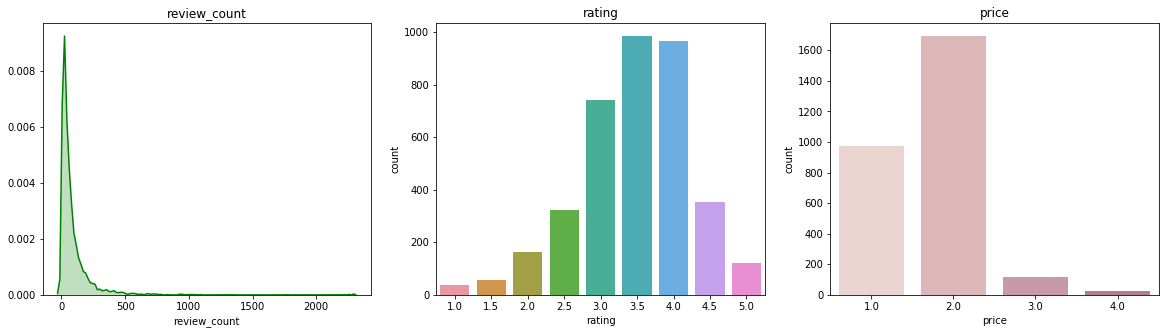

In [5]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.set_palette(sns.cubehelix_palette(8))
sns.distplot(df['review_count'], hist=False, color="g", ax=axes[0], kde_kws={"shade": True}).set_title('review_count')
sns.countplot(df['rating'],ax=axes[1]).set_title('rating')
sns.countplot(df['price'],ax=axes[2]).set_title('price')
plt.show()

Now, let's take a look at some boxplots to see how the data is distributed and the outliers.

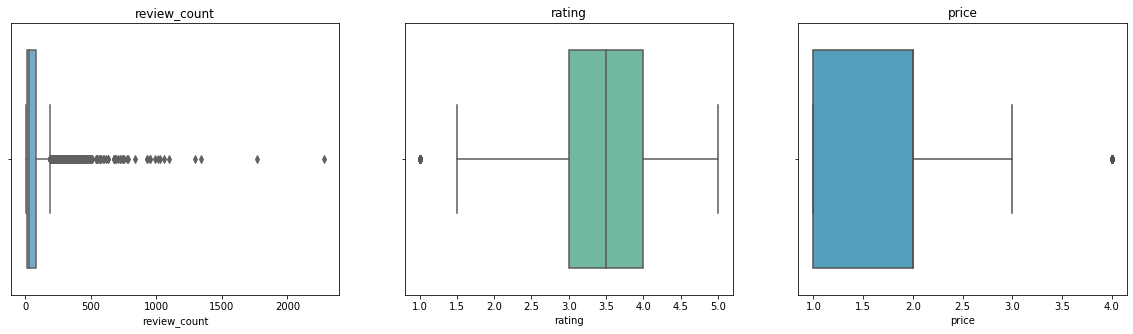

In [6]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(df['review_count'],ax=axes[0],palette='Blues').set_title('review_count')
sns.boxplot(df['rating'],ax=axes[1], palette='BuGn_r').set_title('rating')
sns.boxplot(df['price'],ax=axes[2], palette='GnBu_d').set_title('price')
plt.show()

In the review_count boxplot, it seems like the data surpasses much past the whiskers of the maximum value, which classify them as outliers. This irregular distribution is represented as well in the right skewed distribution plot above. 

When looking at rating data, it seems that most data fall within 3.0 - 4.0, with a rating of 1.0 classified as outliers. This can be due to a few restaurants that seem to attract particularly only negative reviews. When talking about restaurant ratings, it would make sense that only a few restaurants have a 1.0 rating. Most restaurants, which have work put into them, would average to be even a little higher than the absolute minimum. A possible explanation for the restaurants with a 1.0 rating is that they are new and only have a couple of ratings on Yelp.


Similarly, only a few restaurants do have the 4.0 price label, which put them as outliers. As a local in Vancouver, it makes sense that there are few restaurants categorized with a 4.0, as we are not a city with a large number of particularly extravant and high class restaurants.

<a id="categorical"></a>
## Categorical assessment of review_count, rating, price, total number

In this next section, we find these same statistics by category. The Bayesian average of each property was used to graph it by category, in descending order.

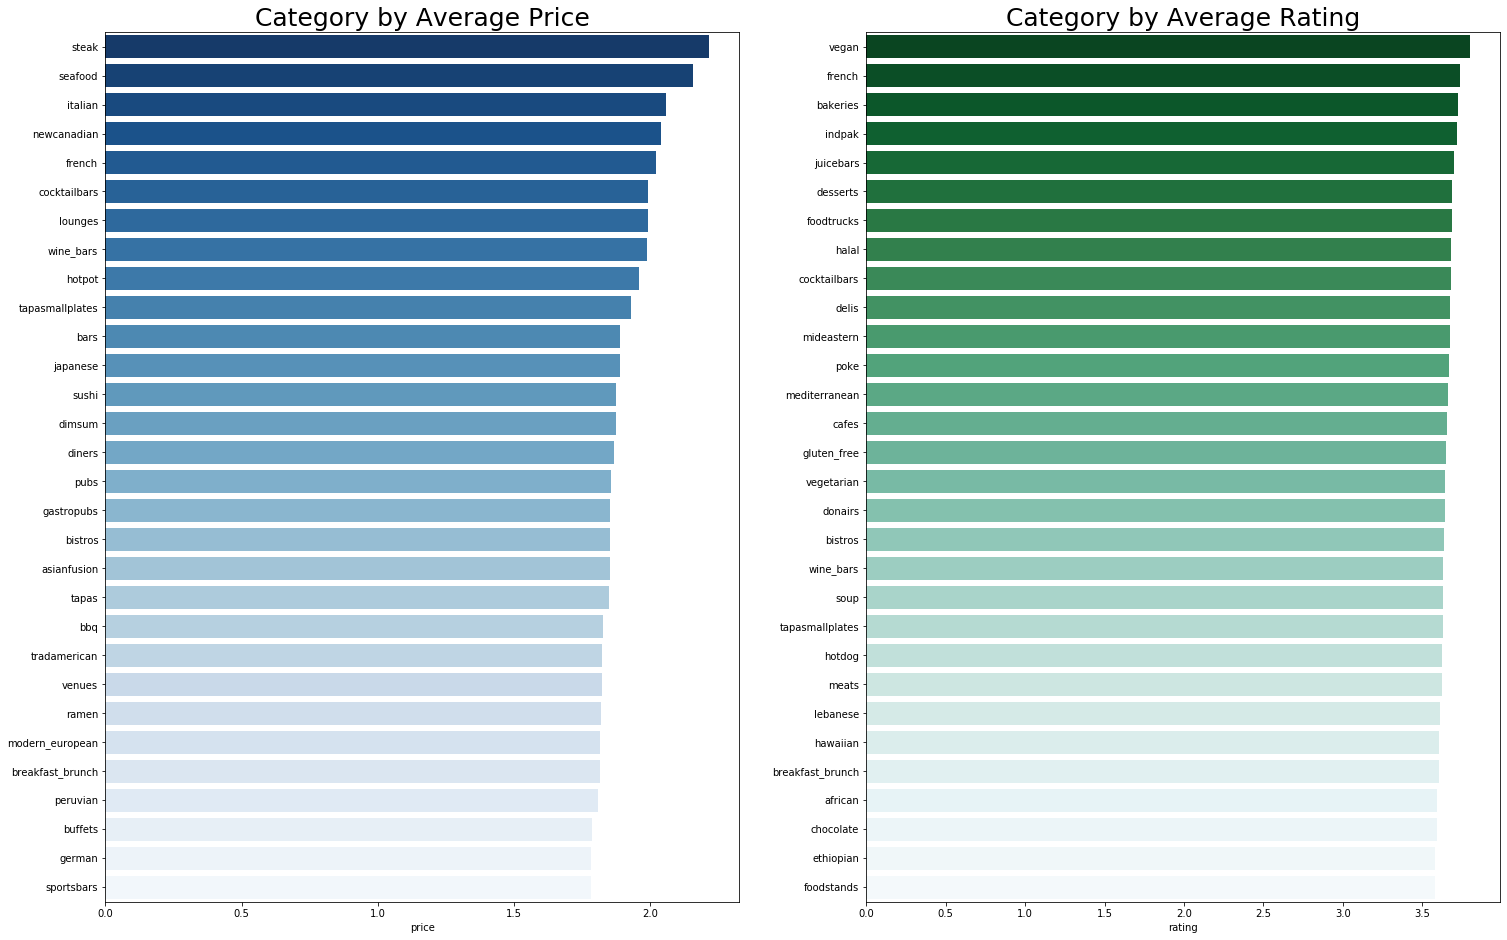

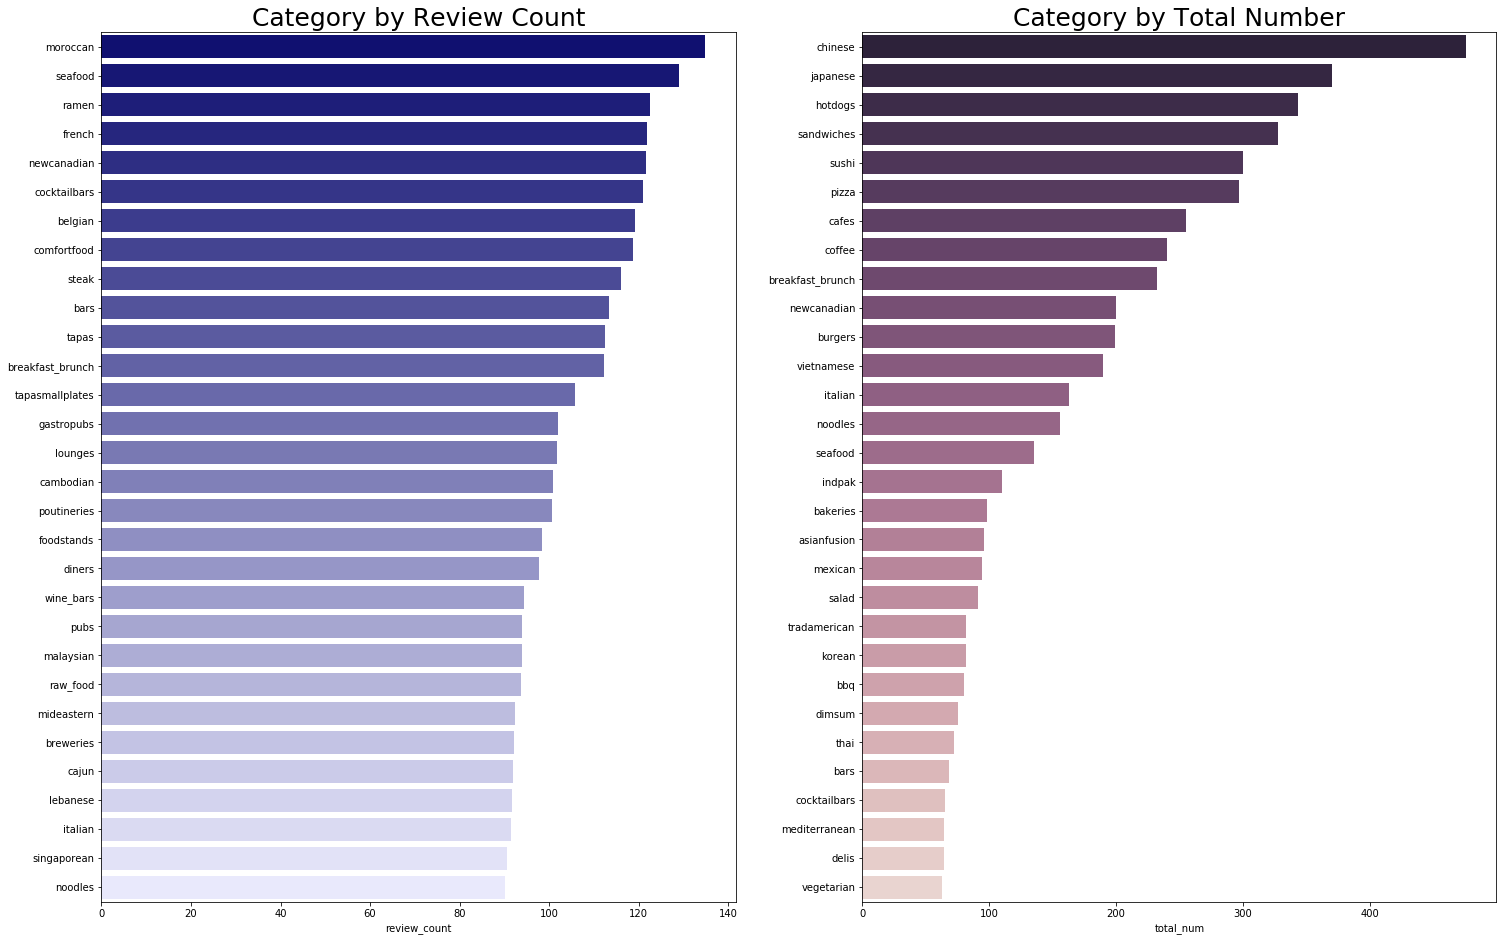

In [7]:
n = 30

### PRICE ###
pr = (bayes_avg(df_expanded.dropna(how='any'), 'alias', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:n]
### RATING
ra = (bayes_avg(df_expanded, 'alias', 'rating').sort_values(ascending=False)
     .reset_index().sort_values('rating', ascending=False))
ra = ra.iloc[:n]
### REVIEW_COUNT
re = (bayes_avg(df_expanded, 'alias', 'review_count').sort_values(ascending=False)
     .reset_index().sort_values('review_count', ascending=False))
re = re.iloc[:n]
### NUMBER OF RESTAURANTS
nu = (df.drop(['id', 'r_alias', 'name','url','review_count','rating','coordinates','price','location', \
         'distance', 'title'], axis=1).sum().sort_values(ascending=False))
nu = nu.reset_index().iloc[:n]
nu.rename(columns={'index': 'alias', 0:'total_num'}, inplace=True)




# first fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))
sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=n, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

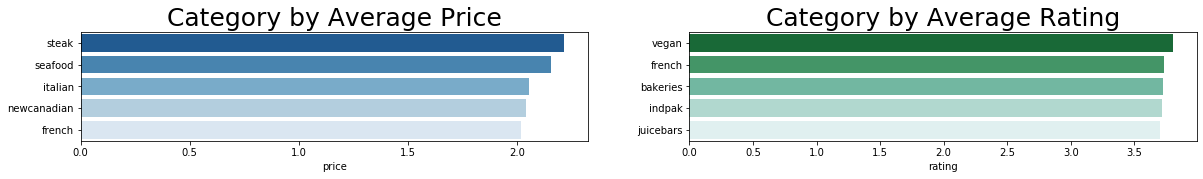

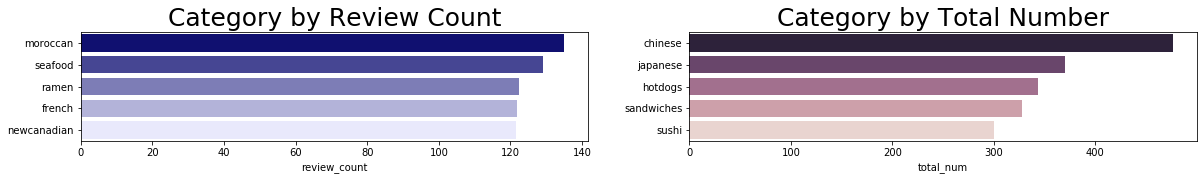

In [8]:
# let's map the top 5 of each category
m = 5

pr,ra,re,nu = pr.iloc[:m], ra.iloc[:m], re.iloc[:m], nu.iloc[:m]

#first fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette(sns.cubehelix_palette(8))

sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=m, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

Woah! The categories for each property, except total number, are pretty similar! As expected, steaks, seafood, canadian and french foods are expensive. Vancouver does vegan, french and pastries best, and chinese and japanese restaurants are most common.

What surprises me most is the amount of reviews for moroccan and seafood restaurants. You'd think that the more popular a category, the more common the review count. However, there are not many chinese restaurant reviews, which takes the most total number of restaurants by a large amount.

# Geographic Data

I was able to find a geoJSON file that has Vancouver zip code boundary coordinates, which can be found [here](https://github.com/codeforamerica/click_that_hood/blob/master/public/data/vancouver.geojson).

Unfortunately, the Vancouver geojson file did not include an easily usable "key" for my data to attach to, such as a zip code, so I had to solve the problem of working with the only usable key, "name", the name of the region.

Using [this](https://www.geonames.org/postal-codes/CA/BC/british-columbia.html) site, I was able to find the zip code respective to the areas that I wanted to use.

With that, came the work of trying to create a new column that corresponded to the "key" in the geojson file. I mapped the zip code to the exact name of the area in question.

Limitations: 
This geojsn file only includes Vancouver. This means that the restaurants in North Vancouver, West Vancouver, Burnaby, Richmond, and further are not included in the maps.

In [9]:
import folium

with open('data/vancouver.geojson','r') as f:
    geojson = json.load(f)

# edit current dataframe to be readable by folium
df['zip_code'] = pd.concat([df.drop(['location'], axis=1), df['location'].apply(pd.Series)], axis=1)['zip_code']

### Applying zip code to location:

In [10]:
df['length'] = df['zip_code'].apply(lambda x: len(x))
df['length'].value_counts()

7    3594
3     131
0      25
5       2
Name: length, dtype: int64

Looks like the zip data comes in different lengths.

Exploring the data, zip codes that have a length of 3 and 7 are in postal code format. Zip codes with length 5 are in the form of American zip codes. Because there are only 27 missing zip codes, we will ignore those.

In [11]:
def zip_to_location(zip_code):
    zip_to_loc_dict = {"V6N": "Dunbar Southlands",
                       "V5K": "Hastings-Sunrise",
                       "V5T": "Mount Pleasant",
                       "V6Z": "Downtown",
                       "V6B": "Downtown",
                       "V7X": "Downtown",
                       "V7Y": "Downtown",
                       "V6E": "West End",
                       "V6G": "West End",
                       "V7T": "West End",
                       "V5S": "Killarney",
                       "V6M": "Kerrisdale",
                       "V5X": "Sunset",
                       "V6P": "Marpole",
                       "V6K": "Kitsilano",
                       "V6R": "Kitsilano",
                       "V6J": "Fairview",
                       "V5P": "Victoria-Fraserview",
                       "V6S": "West Point Grey",
                       "V5W": "Oakridge",
                       "V5R": "Renfrew-Collingwood",
                       "V5M": "Renfrew-Collingwood",
                       "V5V": "Riley Park",
                       "V5Y": "Riley Park",
                       "V6H": "Shaughnessy",
                       "V5L": "Grandview-Woodland",
                       "V5N": "Kensington-Cedar Cottage",
                       "V6L": "Arbutus Ridge",
                       "V5Z": "South Cambie",
                       "V6A": "Downtown Eastside"}
    
    if len(zip_code) == 5 or len(zip_code) == 0:
        return ''
    else:
        return zip_to_loc_dict.get(zip_code[:3], zip_code[:3])

    return "None" 

df['area'] = df['zip_code'].apply(zip_to_location)

<a id="geography"></a>

### Average rating by area

In [12]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)
vancouver_map.choropleth(geo_data=geojson, data=df, columns=['area', 'rating'], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

In this map: missing data is in grey.
Reasoning for this: Zip code "V6A" is both Strathcona and Downtown Eastside, so they can't be placed into both.

### Restaurant density by area

In [13]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)
df_total_by_zip = df.groupby(['area']).size().reset_index()
vancouver_map.choropleth(geo_data=geojson, data=df_total_by_zip, columns=['area', 0], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

### Price by area

In [14]:
print("Amount of missing price data: {}".format(df.price.isnull().sum()))
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)
vancouver_map.choropleth(geo_data=geojson, data=df, columns=['area', 'price'], key_on='feature.properties.name', 
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

Amount of missing price data: 944


In this map: missing data is in grey.
Reasoning for this: Zip code "V6A" is both Strathcona and Downtown Eastside, so they can't be placed into both.
    
Unfortunately, there is too much missing data for 'price'.

### Review count by area

In [15]:
vancouver_map = folium.Map(
    location=[49.240611, -123.114665],
    #tiles='Stamen Terrain',
    zoom_start=12
)
vancouver_map.choropleth(geo_data=geojson, data=df, columns=['area', 'review_count'], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
vancouver_map

In this map: missing data is in grey. Reasoning for this: Zip code "V6A" is both Strathcona and Downtown Eastside, so they can't be placed into both.

### And that's all folks! Thanks for taking the time to look at my project.